[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/infinite-Joy/natural_language_processing_for_professionals/blob/master/notebooks/chapter_6_evaluation_methods.ipynb)

## download the data

`Video_Games_5.json.gz` files are downloaded from the respective url locations. This is done using `wget` command.

In [ ]:
!wget https://github.com/infinite-Joy/natural_language_processing_for_professionals/raw/main/data/Video_Games.json.gz

--2023-05-11 15:49:18--  https://github.com/infinite-Joy/natural_language_processing_for_professionals/raw/main/data/Video_Games.json.gz
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/infinite-Joy/natural_language_processing_for_professionals/main/data/Video_Games.json.gz [following]
--2023-05-11 15:49:18--  https://media.githubusercontent.com/media/infinite-Joy/natural_language_processing_for_professionals/main/data/Video_Games.json.gz
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 522823613 (499M) [application/octet-stream]
Saving to: ‘Video_Games.json.gz’

Video_Games.json

In [ ]:
import gzip
import json
import pandas as pd
import string
import imblearn

# map punctuation to space
translator = str.maketrans(string.punctuation, ' '*len(string.punctuation)) 

def text_preprocessing(text):
    """
    Preprocess the text for better understanding
    
    """
    text = text.strip()
    text = text.lower()
    text = text.replace('\n', '.')
    return text

def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)

def getDF(path):
    df = {}
    i = 0
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

df = getDF('./Video_Games.json.gz')
df = df[['reviewText', 'overall']]
df = df[df['reviewText'].notnull()]
df['reviewText'] = df['reviewText'].apply(text_preprocessing)
df = df.dropna()
df = df.drop_duplicates()
print(df.shape)

(2191356, 2)


## train test split

spplit the dataset based on the label distribution. The test size is 0.3 and random state is given so that the split is the same for the different lessons.

In [ ]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.3, stratify=df.overall, random_state=42)

X_train = df_train['reviewText']
y_train = df_train['overall']

X_test = df_test['reviewText']
y_test = df_test['overall']

print(len(df_train), len(df_test))

280689 120296


## baseline classifier

A very naive classifier where the labels are assigned randomly.

The precision values for the baseline classifier are according to the distribution of the output class and the recall is 20%. The  matthews correlation coefficient is almost 0 which means that the  classifier has not information on the output label. This is obvious now since we know the model, but sometimes a neural network may also give such values. This is the sign that neural network is also nothing better than a random classfier.

In [ ]:
import random

random.seed(42)

def baseline_classifier(text):
    """
    Baseline classifier returning a label randomly
    """
    return float(random.choice([1, 2, 3, 4, 5]))

predictions = df_test['reviewText'].apply(baseline_classifier)

In [ ]:
from sklearn.metrics import accuracy_score, matthews_corrcoef
from imblearn.metrics import classification_report_imbalanced

print('accuracy from scikitlearn:', accuracy_score(df_test['overall'], predictions))
print('matthews_corrcoef:', matthews_corrcoef(df_test['overall'], predictions))
print('classification_report:\n', classification_report_imbalanced(df_test['overall'], predictions))

accuracy from scikitlearn: 0.1979866329720024
matthews_corrcoef: -0.0028328122350226533
classification_report:
                    pre       rec       spe        f1       geo       iba       sup

          1       0.07      0.20      0.80      0.10      0.40      0.15      8386
          2       0.05      0.19      0.80      0.08      0.39      0.14      6711
          3       0.11      0.20      0.80      0.14      0.40      0.15     13262
          4       0.20      0.20      0.80      0.20      0.40      0.15     24579
          5       0.56      0.20      0.80      0.29      0.40      0.15     67358

avg / total       0.37      0.20      0.80      0.23      0.40      0.15    120296



## Custom accuracy function

In [ ]:
def calculate_acc(gold_labels, preds):
    assert len(gold_labels) == len(preds), "gold labels and predictions should have the same number of values"
    total_values = len(gold_labels)
    matching = sum(int(g==p) for g, p in zip(gold_labels, preds))
    return matching / total_values

print('my accuracy function output', calculate_acc(df_test['overall'].values.tolist(), predictions.values.tolist()))

my accuracy function output 0.1979866329720024


## precision score

In [ ]:
from sklearn.metrics import precision_score

print('scikitlearn precision score:', precision_score(
    df_test['overall'].values.tolist(), predictions.values.tolist(),
    labels=[1], average=None))

def calculate_precision(gold_labels, preds, target_label):
    assert len(gold_labels) == len(preds), "gold labels and predictions should have the same number of values"
    true_positives = sum(int(g==p==target_label) for g, p in zip(gold_labels, preds))
    all_positive_predictions = sum(int(p==target_label) for p in preds)
    return true_positives / all_positive_predictions

print('my precision functions', calculate_precision(
    df_test['overall'].values.tolist(), predictions.values.tolist(), 1))

scikitlearn precision score: [0.06834354]
my precision functions 0.06834353797782558


## recall score

In [ ]:
from sklearn.metrics import recall_score

print('scikitlearn recall score:', recall_score(
    df_test['overall'].values.tolist(), predictions.values.tolist(),
    labels=[1], average=None))

def calculate_recall(gold_labels, preds, target_label):
    assert len(gold_labels) == len(preds), "gold labels and predictions should have the same number of values"
    true_positives = sum(int(g==p==target_label) for g, p in zip(gold_labels, preds))
    all_correct_samples = sum(int(g==target_label) for g in gold_labels)
    return true_positives / all_correct_samples

print('my recall functions', calculate_recall(
    df_test['overall'].values.tolist(), predictions.values.tolist(), 1))

scikitlearn recall score: [0.19699499]
my recall functions 0.19699499165275458


## f1 score

In [ ]:
from sklearn.metrics import f1_score

print('scikitlearn f1 score:', f1_score(
    df_test['overall'].values.tolist(), predictions.values.tolist(),
    labels=[1], average=None))

print('manual f1score calculation:', 2 * 0.06834353797782558 * 0.19699499165275458 / (0.06834353797782558 + 0.19699499165275458))

scikitlearn f1 score: [0.10148043]
manual f1score calculation: 0.10148043491614965


## classification report

In [ ]:
from imblearn.metrics import classification_report_imbalanced

print(classification_report_imbalanced(df_test['overall'], predictions))

                   pre       rec       spe        f1       geo       iba       sup

          1       0.07      0.20      0.80      0.10      0.40      0.15      8386
          2       0.05      0.19      0.80      0.08      0.39      0.14      6711
          3       0.11      0.20      0.80      0.14      0.40      0.15     13262
          4       0.20      0.20      0.80      0.20      0.40      0.15     24579
          5       0.56      0.20      0.80      0.29      0.40      0.15     67358

avg / total       0.37      0.20      0.80      0.23      0.40      0.15    120296



## confusion matrix

the output as per the scikit learn documentation

Confusion matrix whose i-th row and j-th column entry indicates the number of samples with true label being i-th class and predicted label being j-th class.

annot=True to annotate cells, ftm='g' to disable scientific notation

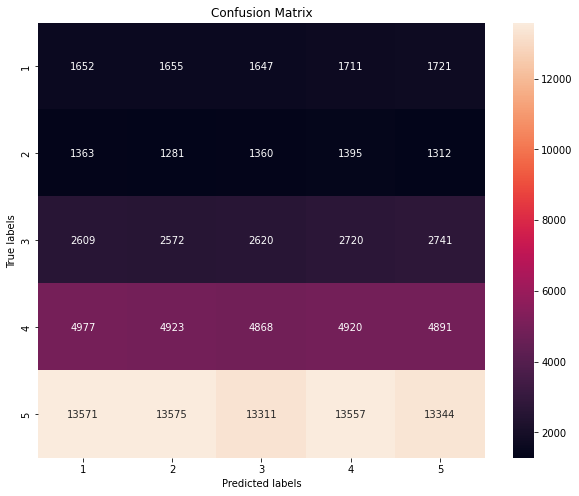

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
%matplotlib inline

def plot_confusion_mat(cf_mat, labels):
    plt.figure(figsize=(10, 8))
    ax = plt.subplot()
    sn.heatmap(cf_mat, annot=True, fmt='g', ax=ax, xticklabels=labels, yticklabels=labels)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    plt.show()


labels = [1,2,3,4,5]
cf_mat = confusion_matrix(df_test['overall'], predictions, labels=labels)
plot_confusion_mat(cf_mat, labels)

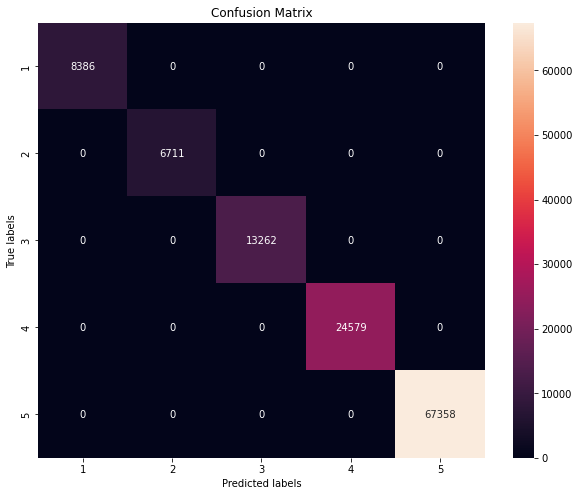

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
%matplotlib inline


labels = [1,2,3,4,5]
cf_mat = confusion_matrix(df_test['overall'].values.tolist(), df_test['overall'].values.tolist(), labels=labels)
plot_confusion_mat(cf_mat, labels)

## matthews correlation coefficient

In [ ]:
from sklearn.metrics import matthews_corrcoef

print('MCC for random output:', matthews_corrcoef(
    df_test['overall'], predictions))
print('MCC where only one class is predicted:', matthews_corrcoef(
    df_test['overall'], [1] * len(df_test['overall'])))
print('MCC where all classes are correctly predicted:', matthews_corrcoef(
    df_test['overall'], df_test['overall']))
print('MCC where all classes are incorrectly predicted:', matthews_corrcoef(
    df_test['overall'], [(val + 1) % 6 for val in df_test['overall'].values.tolist()]))

MCC for random output: -0.0028328122350226533
MCC where only one class is predicted: 0.0
MCC where all classes are correctly predicted: 1.0
MCC where all classes are incorrectly predicted: -0.23530472461061017
